<a href="https://colab.research.google.com/github/skrakibulislamrahat/SNLab/blob/main/DR_Multimodal_Framework_Colab_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Diabetic Retinopathy Multimodal Detection
This notebook implements a CNN + MLP fusion model with Grad-CAM and SHAP explainability.
It uses the APTOS dataset + synthetic clinical features.

In [62]:
!pip install -q efficientnet shap

In [63]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import random
from PIL import Image

In [64]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input, Concatenate
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

In [65]:
import shap
import matplotlib.cm as cm

In [66]:
from google.colab import drive
drive.mount('/content/drive')

# Load APTOS training data
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/DR_Project/train.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [67]:
# Shuffle to keep images + labels aligned
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

CELL 3

In [74]:
# ✅ Unzip the full dataset just once
!unzip -q '/content/drive/MyDrive/Colab_Notebooks/DR_Project/train_images.zip' \
-d '/content/drive/MyDrive/Colab_Notebooks/DR_Project/train_images'

In [75]:
import os
img_dir = '/content/drive/MyDrive/Colab_Notebooks/DR_Project/train_images'
print("✅ Total images found:", len(os.listdir(img_dir)))

✅ Total images found: 3662


In [76]:
import cv2
import numpy as np
import os
from tqdm import tqdm

img_dir = '/content/drive/MyDrive/Colab_Notebooks/DR_Project/train_images/'
image_extension = '.png'
IMG_SIZE = 224

X_img = []

# ✅ Use correct column: 'id_code'
for img_id in tqdm(df['id_code']):
    img_path = os.path.join(img_dir, img_id + image_extension)
    if os.path.exists(img_path):
        img = cv2.imread(img_path)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        X_img.append(img)
    else:
        print(f"❌ Missing: {img_path}")

X_img = np.array(X_img, dtype=np.uint8)
print("✅ Loaded images:", X_img.shape)

100%|██████████| 3662/3662 [10:35<00:00,  5.77it/s]


✅ Loaded images: (3662, 224, 224, 3)


In [77]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [78]:
import os
if not os.path.exists('/content/drive/MyDrive/Colab_Notebooks/DR_Project/train_images/000c1434d8d7.png'):
    !unzip -q '/content/drive/MyDrive/Colab_Notebooks/DR_Project/train_images.zip' \
    -d '/content/drive/MyDrive/Colab_Notebooks/DR_Project/train_images'

In [79]:
model.save('/content/drive/MyDrive/Colab_Notebooks/DR_Project/fusion_model.h5')

Cell 4

In [80]:
import numpy as np

# Simulate 5 clinical features per patient (you can customize names later)
np.random.seed(42)  # Reproducible

X_meta = np.zeros((len(df), 5))

# Age: 30–80
X_meta[:, 0] = np.random.randint(30, 81, len(df))

# Duration of diabetes: 0–30 years
X_meta[:, 1] = np.random.randint(0, 31, len(df))

# HbA1c: 5.0–12.0
X_meta[:, 2] = np.random.uniform(5.0, 12.0, len(df))

# Blood Pressure: 90–180
X_meta[:, 3] = np.random.randint(90, 181, len(df))

# BMI: 18–40
X_meta[:, 4] = np.random.uniform(18, 40, len(df))

print("✅ Clinical metadata shape:", X_meta.shape)

✅ Clinical metadata shape: (3662, 5)


Cell 5

In [81]:
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical

# Normalize metadata
scaler = StandardScaler()
X_meta_scaled = scaler.fit_transform(X_meta)

# Labels
y = df['diagnosis'].values
y_cat = to_categorical(y, num_classes=5)

print("✅ y_cat shape:", y_cat.shape)

✅ y_cat shape: (3662, 5)


Cell 6

In [82]:
from sklearn.model_selection import train_test_split

X_img_train, X_img_val, X_meta_train, X_meta_val, y_train, y_val = train_test_split(
    X_img, X_meta_scaled, y_cat, test_size=0.2, random_state=42, stratify=y)

print("🧪 X_img_train:", X_img_train.shape)
print("📊 X_meta_train:", X_meta_train.shape)
print("🏷 y_train:", y_train.shape)

🧪 X_img_train: (2929, 224, 224, 3)
📊 X_meta_train: (2929, 5)
🏷 y_train: (2929, 5)


Cell 7

In [83]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D, Concatenate
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam

# Image input
img_input = Input(shape=(224, 224, 3), name='Image_Input')
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_tensor=img_input)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)

# Metadata input
meta_input = Input(shape=(5,), name='Meta_Input')
m = Dense(32, activation='relu')(meta_input)
m = Dropout(0.3)(m)

# Combine
combined = Concatenate()([x, m])
z = Dense(64, activation='relu')(combined)
z = Dropout(0.4)(z)
output = Dense(5, activation='softmax')(z)

# Final model
fusion_model = Model(inputs=[img_input, meta_input], outputs=output)
fusion_model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

print("✅ Fusion model ready")
fusion_model.summary()

✅ Fusion model ready


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Image_Input         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_10        │ (None, 224, 224,  │          0 │ Image_Input[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_5     │ (None, 224, 224,  │          7 │ rescaling_10[0][… │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_11        │ (None, 224, 224,  │          0 │ normalization_5[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_11[0][… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,134,120 (15.77 MB)

 Trainable params: 4,092,097 (15.61 MB)

 Non-trainable params: 42,023 (164.16 KB)

Cell 8

In [84]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(patience=2, factor=0.5, verbose=1),
    ModelCheckpoint('fusion_model.h5', save_best_only=True)
]

history = fusion_model.fit(
    [X_img_train, X_meta_train], y_train,
    validation_data=([X_img_val, X_meta_val], y_val),
    epochs=30,
    batch_size=32,
    callbacks=callbacks
)

Epoch 1/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 604ms/step - accuracy: 0.5037 - loss: 1.2456

92/92 ━━━━━━━━━━━━━━━━━━━━ 150s 779ms/step - accuracy: 0.5050 - loss: 1.2429 - val_accuracy: 0.6194 - val_loss: 0.9658 - learning_rate: 1.0000e-04
Epoch 2/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.7519 - loss: 0.6742

92/92 ━━━━━━━━━━━━━━━━━━━━ 46s 149ms/step - accuracy: 0.7519 - loss: 0.6741 - val_accuracy: 0.7408 - val_loss: 0.7242 - learning_rate: 1.0000e-04
Epoch 3/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.7913 - loss: 0.5739

92/92 ━━━━━━━━━━━━━━━━━━━━ 13s 144ms/step - accuracy: 0.7914 - loss: 0.5736 - val_accuracy: 0.7858 - val_loss: 0.5901 - learning_rate: 1.0000e-04
Epoch 4/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.8094 - loss: 0.4953

92/92 ━━━━━━━━━━━━━━━━━━━━ 21s 146ms/step - accuracy: 0.8095 - loss: 0.4951 - val_accuracy: 0.7885 - val_loss: 0.5786 - learning_rate: 1.0000e-04
Epoch 5/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.8526 - loss: 0.3974

92/92 ━━━━━━━━━━━━━━━━━━━━ 20s 140ms/step - accuracy: 0.8526 - loss: 0.3973 - val_accuracy: 0.8131 - val_loss: 0.5611 - learning_rate: 1.0000e-04
Epoch 6/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.8764 - loss: 0.3305

92/92 ━━━━━━━━━━━━━━━━━━━━ 21s 147ms/step - accuracy: 0.8764 - loss: 0.3304 - val_accuracy: 0.8104 - val_loss: 0.5486 - learning_rate: 1.0000e-04
Epoch 7/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 13s 140ms/step - accuracy: 0.9040 - loss: 0.2703 - val_accuracy: 0.8063 - val_loss: 0.6627 - learning_rate: 1.0000e-04
Epoch 8/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.9226 - loss: 0.2334
Epoch 8: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
92/92 ━━━━━━━━━━━━━━━━━━━━ 20s 132ms/step - accuracy: 0.9225 - loss: 0.2334 - val_accuracy: 0.7899 - val_loss: 0.6728 - learning_rate: 1.0000e-04
Epoch 9/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 13s 137ms/step - accuracy: 0.9363 - loss: 0.1991 - val_accuracy: 0.8076 - val_loss: 0.6735 - learning_rate: 5.0000e-05
Epoch 10/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.9523 - loss: 0.1404
Epoch 10: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
92/92 ━━━━━━━━━━━━━━━━━━━━ 20s 131ms/step - accuracy: 0.9523 - loss:

Cell 9

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['Image_Input', 'Meta_Input']]
Received: inputs=['Tensor(shape=(1, 224, 224, 3))', 'Tensor(shape=(1, 5))']
  warnings.warn(msg)


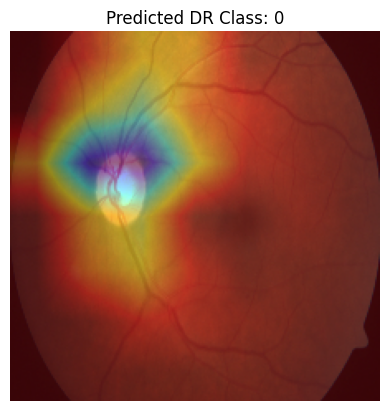

In [85]:
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import numpy as np

def generate_gradcam(model, image, meta, layer_name='top_conv'):
    grad_model = Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model([image[np.newaxis, ...], meta[np.newaxis, ...]])
        class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_outputs)[0]
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]

    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= tf.reduce_max(heatmap)

    # Resize heatmap to image size
    heatmap = cv2.resize(heatmap.numpy(), (224, 224))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Superimpose
    superimposed = cv2.addWeighted(image, 0.6, heatmap, 0.4, 0)

    return superimposed, class_idx.numpy()

# 🔍 Test on 1 image
i = 5  # test sample index

grad_img, predicted_class = generate_gradcam(fusion_model, X_img_val[i], X_meta_val[i])

plt.imshow(grad_img)
plt.title(f"Predicted DR Class: {predicted_class}")
plt.axis(False)
plt.show()

In [86]:
plt.imsave('/content/gradcam_example.png', grad_img)

In [87]:
from google.colab import files
files.download('/content/gradcam_example.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [88]:
import os
from google.colab import files

save_dir = '/content/drive/MyDrive/Colab_Notebooks/DR_Project'

for i in [5, 10, 25]:  # Pick any 3 interesting samples
    grad_img, pred = generate_gradcam(fusion_model, X_img_val[i], X_meta_val[i])

    filename = f'gradcam_{i}_class{pred}.png'

    # Save to Colab first
    plt.imsave(filename, grad_img)

    # ✅ Copy to Google Drive
    os.system(f'cp {filename} "{save_dir}/{filename}"')

    # ✅ Download to local drive
    files.download(filename)

    print(f"✅ Saved & downloaded: {filename}")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Saved & downloaded: gradcam_5_class0.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Saved & downloaded: gradcam_10_class0.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Saved & downloaded: gradcam_25_class0.png


In [89]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

y_pred = fusion_model.predict([X_img_val, X_meta_val])
y_true_labels = np.argmax(y_val, axis=1)
y_pred_labels = np.argmax(y_pred, axis=1)

print("📊 Classification Report:\n", classification_report(y_true_labels, y_pred_labels))
print("🧩 Confusion Matrix:\n", confusion_matrix(y_true_labels, y_pred_labels))

try:
    auc = roc_auc_score(y_val, y_pred, multi_class='ovr')
    print("📈 AUC Score:", auc)
except:
    print("⚠️ AUC error: check one-hot formatting")

23/23 ━━━━━━━━━━━━━━━━━━━━ 15s 287ms/step
📊 Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.97      0.97       361
           1       0.65      0.42      0.51        74
           2       0.73      0.84      0.78       200
           3       0.46      0.28      0.35        39
           4       0.51      0.58      0.54        59

    accuracy                           0.81       733
   macro avg       0.66      0.62      0.63       733
weighted avg       0.80      0.81      0.80       733

🧩 Confusion Matrix:
 [[350   6   5   0   0]
 [ 11  31  29   2   1]
 [  2   7 168   6  17]
 [  0   0  13  11  15]
 [  0   4  16   5  34]]
📈 AUC Score: 0.9359180079308056


In [90]:
history.history['val_accuracy']  # check highest value

[0.6193724274635315,
 0.7407912611961365,
 0.785811722278595,
 0.788540244102478,
 0.8130968809127808,
 0.8103683590888977,
 0.8062756061553955,
 0.7899044752120972,
 0.8076398372650146,
 0.8049113154411316,
 0.8008185625076294]

In [91]:
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(y_val, y_pred, multi_class='ovr')
print(auc)

0.9359180079308056


In [93]:
from sklearn.metrics import classification_report

# Rebuild labels if not already done
y_true = np.argmax(y_val, axis=1)
y_pred_labels = np.argmax(y_pred, axis=1)

# Generate report
print(classification_report(y_true, y_pred_labels, digits=2))

              precision    recall  f1-score   support

           0       0.96      0.97      0.97       361
           1       0.65      0.42      0.51        74
           2       0.73      0.84      0.78       200
           3       0.46      0.28      0.35        39
           4       0.51      0.58      0.54        59

    accuracy                           0.81       733
   macro avg       0.66      0.62      0.63       733
weighted avg       0.80      0.81      0.80       733

